# 패키지 로딩

In [1]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.options.display.float_format = '{:.2f}'.format

# 데이터 로딩 

In [3]:
# 수요 관련 데이터 로딩 
data=pd.read_csv('./구리 수요/1995_01-2023_03 수요 데이터 전처리') 
data.drop('Unnamed: 0',axis=1,inplace=True)
#print(data.head())

# 독립변수 / 종속변수 데이터 셋 나누기 
x_data=data.drop(columns=['Dates','PX_LAST']) 
x_data.rename(columns={'Copper price':'copper_price'},inplace=True)
print(x_data) 

y_data=data['PX_LAST']
print(y_data)

     HSI_value  CCI_value  IPI_value  GDPC_value  copper_price
0         1407     100.83      71.28    10550.25          1.38
1         1316     100.95      71.19    10550.25          1.32
2         1249     101.02      71.29    10550.25          1.35
3         1267     100.99      71.16    10581.72          1.33
4         1314     100.99      71.50    10581.72          1.26
..         ...        ...        ...         ...           ...
334       1427      96.77     103.07    20182.49          3.66
335       1357      97.27     101.48    20182.49          3.82
336       1340      97.73     102.51    20246.44          4.12
337       1436      98.16     102.50    20246.44          4.08
338       1380      98.41     102.65    20246.44          4.03

[339 rows x 5 columns]
0      969917.00
1      960039.00
2     1043928.00
3     1022904.00
4      979813.00
         ...    
334   2237807.24
335   2148356.12
336   2121282.62
337   1975076.39
338   2168189.61
Name: PX_LAST, Length: 339, dtype

# 종속변수 및 독립변수의 관계

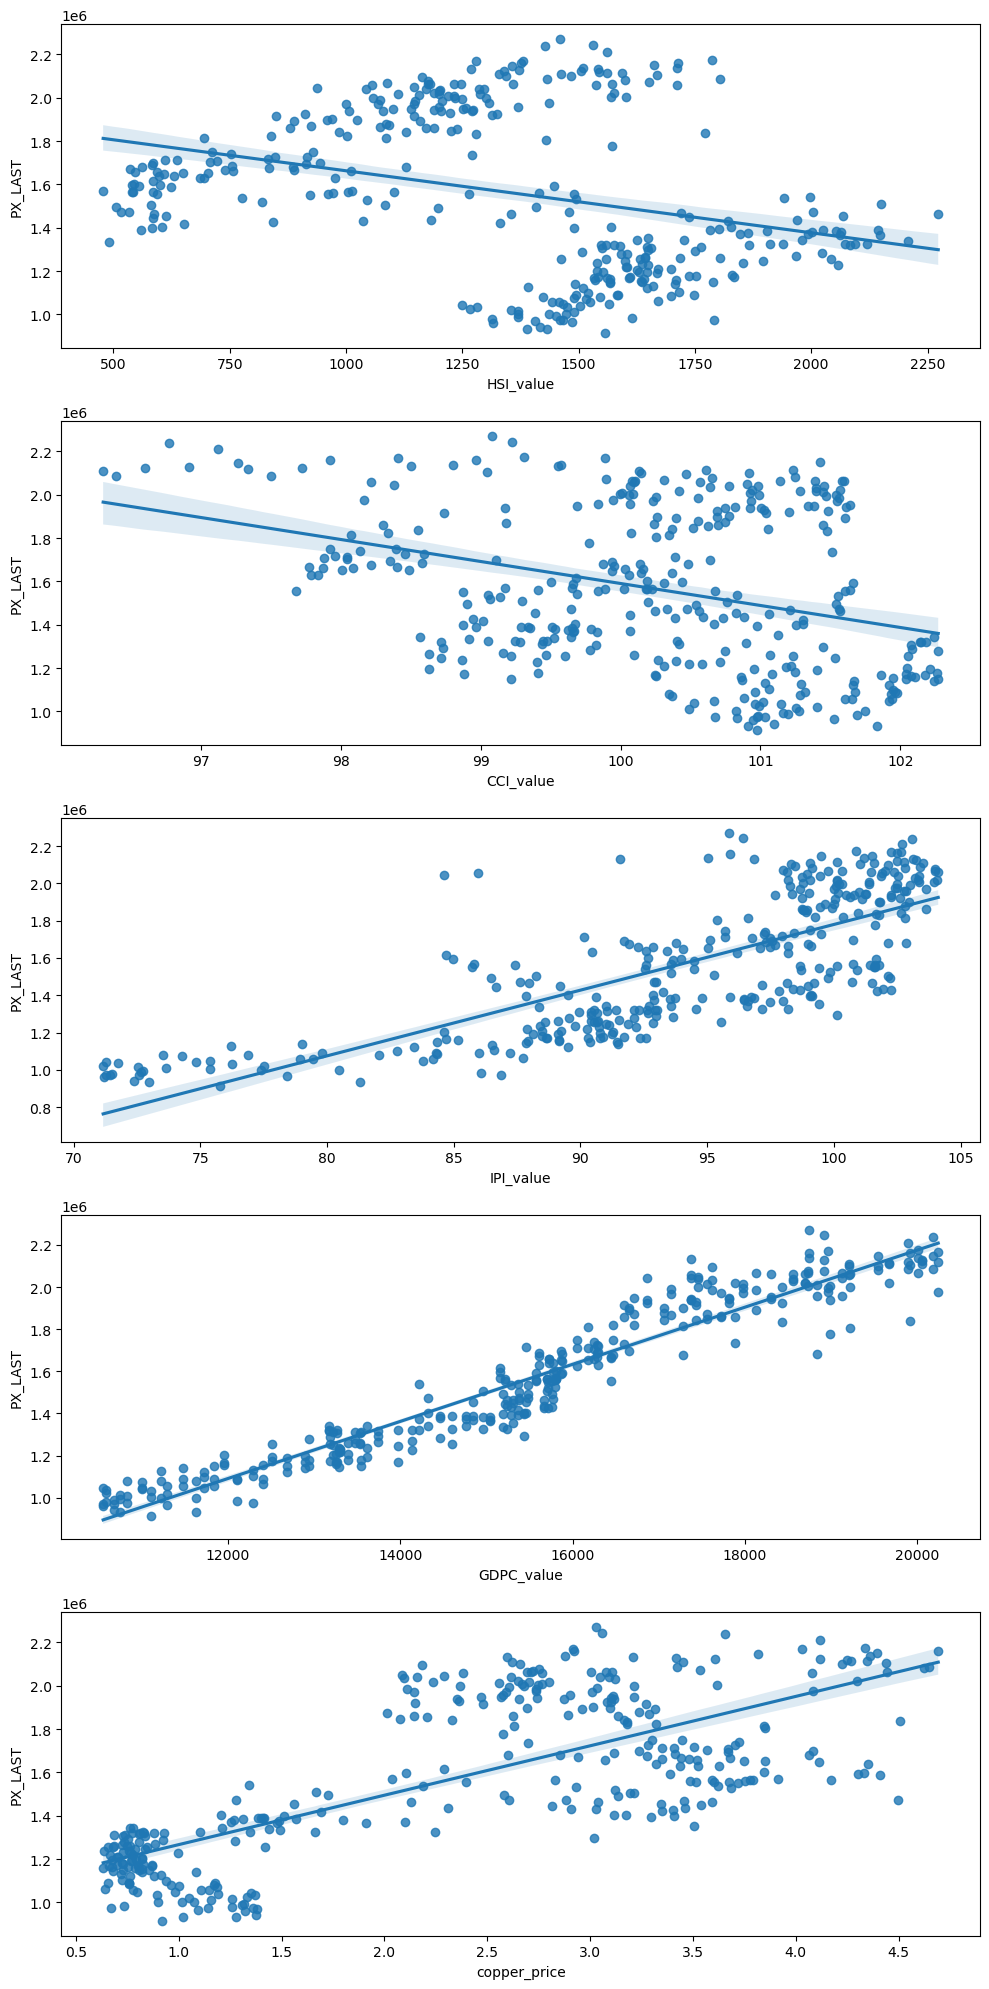

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# subplot을 각 독립변수의 개수만큼 생성하기 위해 행의 개수를 조정
fig, axis = plt.subplots(len(x_data.columns),1, figsize=(10, 20))

# 각 독립변수와 종속변수의 산점도 및 회귀선 그리기
for i, col in enumerate(x_data.columns):
    sns.regplot(data=x_data, x=x_data[col], y=y_data, ax=axis[i])
    axis[i].set_xlabel(col)  # x축 레이블 설정
    axis[i].set_ylabel('PX_LAST')  # y축 레이블 설정

plt.tight_layout()
# 이미지 파일로 저장
plt.savefig('regression_plot.jpg')
plt.show()

# 선형회귀 모델

## Linear Regression

In [5]:
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

### 데이터 표준화 및 정규화

In [6]:
scaler=StandardScaler()
scaled_x=scaler.fit_transform(x_data)

In [7]:
scaler=MinMaxScaler()
scaled_x=scaler.fit_transform(x_data)

### 학습 - 평가 데이터 분리

In [53]:
x_train,x_test,y_train,y_test=train_test_split(scaled_x,y_data,test_size=0.3,random_state=10)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((237, 5), (237,), (102, 5), (102,))

### 모델생성

In [63]:
model = LinearRegression()
model.fit(x_train, y_train) 

LinearRegression()

### 모델 평가 및 예측

In [67]:
# 결정계수 확인
r_square=model.score(x_test,y_test)
print(f'결정계수:{r_square:.2f}') 

# 추정계수(가중치) 확인
weight={f:w for f,w in zip(x_data.columns, model.coef_)} 
print(pd.Series(weight).sort_values(ascending=False))  

# 절편 출력
print('절편:', model.intercept_)

결정계수:0.93
GDPC_value     1475316.55
CCI_value        91398.81
copper_price    -56307.18
HSI_value      -162286.18
IPI_value      -171952.98
dtype: float64
절편: 973021.1477935571


In [73]:
#  예측값
y_hat=model.predict(x_test) 
mse=mean_squared_error(y_test,y_hat)

print(f'MSE:{mse:.2f}') # 모델이 예측한 값과 실제 값 간의 평균 제곱 오차
print(f'RMSE:{np.sqrt(mse):.2f}')  # 모델의 예측값과 실제값 간의 평균 제곱 오차에 루트를 씌운 값

MSE:9331568665.76
RMSE:96600.04


In [81]:
# 실제값, 예측값, 오차, 오차율 df 정리 
linear_regression=pd.DataFrame({'actual':y_test,'predict':y_hat}) 

linear_regression['difference']=abs(linear_regression['actual']-linear_regression['predict'])

linear_regression['percentage(%)']=(linear_regression['difference']/linear_regression['actual'])*100 

display(linear_regression.sort_values('percentage(%)',ascending=False).head(10))
print('평균오차율',round(np.mean(linear_regression['percentage(%)']),2),'%')

,actual,predict,difference,percentage(%)
167,1391388.00,1627071.63,235683.63,16.94
47,974419.00,1109648.42,135229.42,13.88
305,2133884.50,1840478.08,293406.42,13.75
180,1452042.46,1644775.68,192733.22,13.27
193,1470812.32,1660098.65,189286.34,12.87
43,984122.00,1109225.72,125103.72,12.71
175,1446215.82,1619725.80,173509.99,12.00
226,1948450.54,1719203.20,229247.34,11.77
163,1424629.00,1587732.03,163103.03,11.45
337,1975076.39,2178866.38,203789.99,10.32


평균오차율 4.76 %


# Random ForestRegressor

In [2]:
# 패키지 로딩
from sklearn.ensemble import RandomForestRegressor

In [9]:
# 학습-평가 데이터 분리
x_train,x_test,y_train,y_test=train_test_split(scaled_x,y_data,test_size=0.3,random_state=10)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((237, 5), (237,), (102, 5), (102,))

In [11]:
# 모델 생성 및 학습 
n_estimators=20 #  n_estimators : RandomForest 안에 생성할 tree의 개수 지정 
model=RandomForestRegressor(n_estimators=n_estimators,random_state=0) 
model.fit(x_train,y_train) 

RandomForestRegressor(n_estimators=20, random_state=0)

In [16]:
# 모델 평가 (MSE, RMSE, R2Score)
y_hat=model.predict(x_test) 
print(f'MSE: {mean_squared_error(y_test,y_hat):.2f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test,y_hat)):.2f}') 
print(f'R2 Score: {r2_score(y_test, y_hat):.2f}') 

# 종속 변수 data 의 변화 -> MSE, RMSE 오차값 하락 but R2 Score 도 하락함! 

MSE: 7393802918.10
RMSE: 85987.23
R2 Score: 0.94


In [17]:
# 실제값, 예측값, 오차, 오차율 df 정리 
random_forest=pd.DataFrame({'actual':y_test,'predict':y_hat}) 

random_forest['difference']=abs(random_forest['actual']-random_forest['predict'])

random_forest['percentage(%)']=(random_forest['difference']/random_forest['actual'])*100 

display(random_forest.sort_values('percentage(%)',ascending=False).head(10))
print('평균오차율',round(np.mean(random_forest['percentage(%)']),2),'%')

,actual,predict,difference,percentage(%)
19,914458.00,1064503.95,150045.95,16.41
291,2171204.50,1869156.99,302047.51,13.91
47,974419.00,1105404.25,130985.25,13.44
43,984122.00,1110269.20,126147.20,12.82
193,1470812.32,1626849.58,156037.26,10.61
119,1256402.00,1381421.35,125019.35,9.95
311,2073899.00,1871410.69,202488.31,9.76
163,1424629.00,1560003.18,135374.18,9.50
25,965361.00,1055778.55,90417.55,9.37
310,2130682.00,1935453.17,195228.83,9.16


평균오차율 4.37 %


# Voting Regressor

In [3]:
# 패키지 로딩 
from sklearn.linear_model import Lasso, Ridge, LinearRegression 
from sklearn.ensemble import VotingRegressor

In [12]:
# 학습-평가 데이터 분리
x_train,x_test,y_train,y_test=train_test_split(scaled_x,y_data,test_size=0.3,random_state=10)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((237, 5), (237,), (102, 5), (102,))

In [13]:
# 모델 생성
lasso=Lasso(alpha=0.05) 
ridge=Ridge(alpha=1)

linear= LinearRegression() 
voting=VotingRegressor(estimators=[('Lasso',lasso),('Ridge',ridge),('Linear',linear)]) 

# 모델 학습
voting.fit(x_train,y_train)

VotingRegressor(estimators=[('Lasso', Lasso(alpha=0.05)),
                            ('Ridge', Ridge(alpha=1)),
                            ('Linear', LinearRegression())])

In [19]:
# 모델 평가 (RSquare, MSE(RMSE))
y_hat=voting.predict(x_test) 
print(f'RScore : {voting.score(x_test,y_test):.2f}') # 0.89 -> 0.92 
print(f'MSE :{mean_squared_error(y_test,y_hat):.2f}')
print(f'RMSE:{np.sqrt(mean_squared_error(y_test,y_hat)):.2f}')

RScore : 0.92
MSE :9740662056.31
RMSE:98694.79


In [21]:
# 실제값, 예측값, 오차, 오차율 df 정리 
voting=pd.DataFrame({'actual':y_test,'predict':y_hat}) 

voting['difference']=abs(voting['actual']-voting['predict'])

voting['percentage(%)']=(voting['difference']/voting['actual'])*100 

display(voting.sort_values('percentage(%)',ascending=False).head(10))
print('평균오차율',round(np.mean(voting['percentage(%)']),2),'%')

,actual,predict,difference,percentage(%)
167,1391388.00,1613847.92,222459.92,15.99
305,2133884.50,1820022.12,313862.38,14.71
47,974419.00,1115132.26,140713.26,14.44
193,1470812.32,1675509.24,204696.93,13.92
43,984122.00,1114007.50,129885.50,13.20
180,1452042.46,1642906.92,190864.45,13.14
163,1424629.00,1607828.10,183199.10,12.86
175,1446215.82,1611511.26,165295.45,11.43
226,1948450.54,1728974.46,219476.08,11.26
139,1354670.00,1502847.34,148177.34,10.94


평균오차율 4.89 %


# Gradient Boosting Regressor

In [15]:
from sklearn.ensemble import GradientBoostingRegressor 

In [10]:
# 학습-평가 데이터 분리
x_train,x_test,y_train,y_test=train_test_split(scaled_x,y_data,test_size=0.3,random_state=10)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((237, 5), (237,), (102, 5), (102,))

In [11]:
# 모델 생성 및 학습 
gradient=GradientBoostingRegressor(n_estimators=120, max_depth=6)
gradient.fit(x_train,y_train)

GradientBoostingRegressor(max_depth=6, n_estimators=120)

In [16]:
# 모델 예측 및 성능 평가
y_hat=gradient.predict(x_test)
rsquare=gradient.score(x_test,y_test)
mse=mean_squared_error(y_test,y_hat)
rmse=np.sqrt(mse) 

print(f'RSquare : {rsquare:.2f}')
print(f'MSE : {mse:.2f}')
print(f'RMSE : {rmse:.2f}')

RSquare : 0.91
MSE : 11406225583.06
RMSE : 106799.93


In [17]:
# 실제값, 예측값, 오차, 오차율 df 정리 
grad=pd.DataFrame({'actual':y_test,'predict':y_hat}) 

grad['difference']=abs(grad['actual']-grad['predict'])

grad['percentage(%)']=(grad['difference']/grad['actual'])*100 

display(grad.sort_values('percentage(%)',ascending=False).head(10))
print('평균오차율',round(np.mean(grad['percentage(%)']),2),'%')

,actual,predict,difference,percentage(%)
291,2171204.50,1713883.48,457321.02,21.06
19,914458.00,1081703.77,167245.77,18.29
310,2130682.00,1828991.67,301690.33,14.16
47,974419.00,1108922.53,134503.53,13.80
43,984122.00,1116369.73,132247.73,13.44
311,2073899.00,1797589.74,276309.26,13.32
290,1957887.50,1705683.29,252204.21,12.88
226,1948450.54,1707110.64,241339.89,12.39
322,2135856.66,1897646.73,238209.94,11.15
163,1424629.00,1574395.96,149766.96,10.51


평균오차율 4.86 %
